# Generative Adversarial Networks: from toy to Conditional GANs

The main goal of this lab is to understand how GANs work, how they are trained and what we can achieve with them. In order to do so, this lab is divided in four parts:
*   **Toy GAN**: We will build a tiny GAN model which will take a number as input and generate another. This simple model will help us to understand how these networks are trained and how different hyper-parameters affect this training.
*   **Classic GAN**: We will also build a GAN that learns to generate images of handwritten digits using the MNIST dataset. We'll start generating images of a specific digit (of your choice) and then we'll generalize to a broader task (generating any digit from 0 to 9).
*   **Conditional GAN**: If we want to have control on which digit will be generated, this section will be key to see how to manually condition the digit of the generated image.
*   **Qualitative analysis**: We have trained several models and this will be the time to (qualitatively) see which one works best and what more we can do with these models.

You will have 2 sessions to complete this lab. Take into account that the first two parts are the longest (where most of the code needs to be completed), so don't feel discouraged if you don't finish them in the first session!



But, before you start, let's import some libraries that will help us with the code:

In [1]:
# Generic stuff
import numpy as np
import os
import scipy.stats as stats
import sys
from ipywidgets import interact
from tqdm import tqdm

# Pytorch stuff
import torch
import torchvision
from torch import nn
from torchsummary import summary
from torchvision import transforms
from torchvision.utils import save_image, make_grid

# (Interactive) Plotting stuff
import cv2
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
from IPython.display import Image
from PIL import Image as PImage
from plotly.subplots import make_subplots

We will also download some helper code and pretrained weights of GAN models.

In [2]:
!wget -O mlnn_lab7.1.zip https://ehubox.ehu.eus/s/o9TkkJ4zGEREdXS/download
!unzip -q mlnn_lab7.1.zip 

--2023-01-08 15:33:36--  https://ehubox.ehu.eus/s/o9TkkJ4zGEREdXS/download
Resolving ehubox.ehu.eus (ehubox.ehu.eus)... 158.227.0.95
Connecting to ehubox.ehu.eus (ehubox.ehu.eus)|158.227.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9711572 (9.3M) [application/zip]
Saving to: ‘mlnn_lab7.1.zip’

mlnn_lab7.1.zip     100%[===================>]   9.26M  2.95MB/s    in 3.1s    

2023-01-08 15:33:40 (2.95 MB/s) - ‘mlnn_lab7.1.zip’ saved [9711572/9711572]



Load helper code for this lab.

In [3]:
sys.path.append('/content/mlnn_lab7.1')

from plots import *
from interactive_plots import *
from tensor_manipulation import *

## PART 1: Toy GAN

Today our first goal will be to understand the training process of GANs. Comparing to previous architectures that you have already seen, they are quite tricky to train, as the two neural networks that form a GAN are trained jointly with adversarial objectives.

In short, these two networks have the following objectives.

*   **Generator**: It generates data that is "similar" to some real data we already own (more on what similar really means below) with the goal of fooling the discriminator.
*   **Discriminator**: It learns to distinguish between real and generated/fake data.


<img src="https://www.researchgate.net/profile/Emiliano-De-Cristofaro/publication/317061929/figure/fig1/AS:497029693362176@1495512521469/Generative-Adversarial-Network-GAN.png"/>

### Probability distributions

In order to comprehend what these two networks really do, we first need to remember what probability distributions are and the notation used to describe them. 

In our case, given a set $R$ of real numbers $R \subseteq \mathbb{R}$, the probability distribution $p_{real}$ of $R$ is a mathematical function that defines the probability of a real number $r \in R$ to be sampled randomly from $R$. Technically, this probability will be zero if the set is not discrete and we would need to work with intervals to actually compute relevant probabilities. However, we don't need to learn the probability distribution function explicitly while we work with GANs. Instead, we learn the distribution $p_{real}$ by drawing samples from $R$.

We denote that the sample $r$ is drawn from the probability distribution $p_{real}$ with $r \sim p_{real}(r)$.


There are three key different probability distributions that are important to know when working with GANs.

* $p_z$: probability distribution of the data that the generator takes as input.
* $p_g$: probability distribution of the data that is generated by the generator, which, in other words, is conditioned by $p_z$ and the generator.
* $p_{data}$: probability distribution of the data that the generator wants to replicate, that is, the distribution that follows our training dataset.

So, formally speaking, the generator takes $z$ as input where $z \sim p_z(z)$ and generates data $x = G(z)$, where $x \sim p_g(x)$. The final goal of the generator is to achieve $p_g = p_{data}$. If the previous equality is learnt during training, we could say that $x = G(z) \sim p_{data}(x)$.

### The purpose of Toy GAN

This Toy GAN is one of the simplest GANs you could define. It takes only a number $z \in \mathbb{R}^{1}$ as input (often called latent sample) and generates another number $x \in \mathbb{R}^{1}$. In this case we will manually define $p_z$ and $p_{data}$: 

*   $p_{z}$ will follow a uniform distribution in a finite range.

*   $p_{data} \sim \mathcal{N}(\mu,\,\sigma^{2})$, that is, $p_{data}$ will follow a normal distribution.



The generator should learn to take as input a random value sampled from a uniform distribution $z \sim p_z$ and generate another one that follows a normal distribution $x \sim p_{g} = p_{data}$. 

Due to the low complexity of the model we won't be able to learn a perfect normal distribution, but... ideally, in this part you will see how $p_g$ changes to better resemble $p_{data}$ during the training process and how this change happens due to the discriminator's signal. To do so, we have prepared an interactive plot in the end of this part that shows how this signal and probability distribution evolve during training.

### Data generation

In this part we'll generate samples from $p_z$ and $p_{data}$, a total of $n = 256$ samples for each distribution.

Below we'll define the functions that generate $n$ samples from uniform and normal distributions, respectly. These functions return Pytorch tensors containing those samples, ready to be used in the training process. 

There is a third function that generates a tensor with values uniformely distributed for visualization purposes later on. But you don't need to do anything with it.

**TODO**: implement the sampling method below that takes $n$ numbers from a normal distribution with the given mean and standard deviation values. You may want to check what `np.random.normal()` does...

In [4]:
# Retrieve n samples from our input uniform distribution with range [min, max)
def generate_uniform_batch(n, min=-1, max=1):
    np.random.seed(42) # seed is specified for replication purposes
    data = np.random.uniform(low=min, high=max, size=(n, 1))
    tensor = torch.tensor(data, dtype=torch.float32) 
    return tensor

# Retrieve n samples from our goal normal distribution
def generate_normal_batch(n, mean=0, stdev=1):
    np.random.seed(42) # seed is specified for replication purposes
    ### WRITE YOUR CODE HERE ### (~2 lines)
    data = np.random.normal(mean, stdev, size=(n,1))
    tensor = torch.tensor(data, dtype = torch.float32)
    ############################
    return tensor

# Generate evaluation batch to check what distribution is our Toy GAN generating
# For visualization purposes
def generate_evaluation_batch(n, min=-1, max=1):
    data = np.arange(n) * (max - min) / n + min
    return torch.tensor(data, dtype=torch.float32).reshape((n, 1))

We define the arguments of the normal and uniform distributions as follows...

In [5]:
input_min = -1.5 # minimum value of the uniform distribution
input_max = 1.5 # maximum value of the uniform distribution

mu = 0.4 # mean of the normal distribution
sigma = 0.2 # standard deviation of the normal distribution

... and generate the samples.

In [6]:
n_samples = 256

input_data = generate_uniform_batch(n_samples, input_min, input_max)
real_data = generate_normal_batch(n_samples, mu, sigma)

The following cell shows the mean and standard deviation values of the samples from the normal distribution, which should be really close to the $\mu$ and $\sigma$ values specified above. It also shows the shape of `input_data` and `real_data`, which should be the same.

In [7]:
print(f"Mean of the sampled real data: {torch.mean(real_data).item()}")
print(f"Std. Dev. of the sampled real data: {torch.std(real_data).item()}")

print(f"\nInput data: {input_data.size()}")
print(f"Real data: {real_data.size()}")

Mean of the sampled real data: 0.4001580476760864
Std. Dev. of the sampled real data: 0.19520840048789978

Input data: torch.Size([256, 1])
Real data: torch.Size([256, 1])


### Define networks

Before defining the model, it is important to specify in which device we'll work. Even though this first part is actually faster to be done using the CPU (due to our Toy GAN's tiny size), we'll work with a GPU from the start. 

This is the moment where you should check if your working environment has a GPU. To know this, the following cell should print True.

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


We now define the generator and discriminator models as standard Multi Layer Perceptrons (MLP).

The generator contains four linear layers with the same size on the hidden layers (5). Each linear layer is followed by a relu function except for the last one.

In this case, the discriminator follows a similar architecture. Four linear layers where each one is followed by a relu function. However, after the last linear layer we need a sigmoid activation function to compute the probability of a number being "real" or generated by our network.

To create them we will use `nn.Sequential()` that initializes the layers of the network and creates the forward pass automatically at the same time.

**TODO**: Implement the discriminator following the generator's implementation as example.

In [9]:
# Both input and output have only one value
input_size = 1
hidden_size = 5 
output_size = 1

# Generator 
toy_generator = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)
)

# Discriminator
toy_discriminator = None

### WRITE YOUR CODE HERE ### (~10 lines)
toy_discriminator = nn.Sequential(
    nn.Linear(input_size, hidden_size), 
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size),
    nn.Sigmoid()
)

############################

We will initialize the weights of these networks using Kaiming's initialization and set the biases to zero. To do so, we have already defined `init_toy_weights()` that assigns these values correctly to the linear layers of the networks.

In [10]:
def init_toy_weights(m):
    # Set seed
    torch.manual_seed(1)

    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.0)

# Initialize weights manually
toy_discriminator.apply(init_toy_weights)
toy_generator.apply(init_toy_weights)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)

Finally, we will move both models and samples to the GPU in order to do the training.

In [11]:
# Device setting for models
toy_discriminator = toy_discriminator.to(device)
toy_generator = toy_generator.to(device)

# Device setting for data tensors
input_data = input_data.to(device)
real_data = real_data.to(device)

### Train model

Before starting to code the training process... let's take a quick recap of what we have seen in the theory.

#### Quick recap

The generator and discriminator losses derive from a single measure of distance between probability distributions, composed by two terms. This is often called a **minimax game**, where one agent (or network, in this case) tries to minimize a measure while the other tries to maximize it. $G$ can only affect one term in the distance measure: the second term on the following formula that reflects the distribution of the fake data. So during the generator's training we drop the first term, which reflects the distribution of the real data.

$$\min_{G} \max_{D} V(D,G) = \mathbb{E}_{x \sim p_{data}}[\log (D(x))] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

In this function:

*    $G(z)$ is the generator's output when a noise-vector (or random number in this case) $z$ is given as input.
*    $D(G(z))$ is the discriminator's estimate of the probability that a fake instance is real.
*    $D(x)$ is the discriminator's estimate of the probability that real data instance $x$ is real.
*    $\mathbb{E}_{x \sim p_{data}}$ is the expected value over all real data instances.
*    $\mathbb{E}_{z \sim p_{z}}$ is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances $G(z)$).

As previously mentioned, the generator can't directly affect the $\log (D(x))$ term in the function, so, for the generator, minimizing the loss is equivalent to minimizing $\log (1 - D(G(z)))$.

Although theoretically this should work, in practice the discriminator's task is much easier than the generator's and the learning process becomes harder. In other words, if $D$ learns too quickly, $G$ won't be able to converge.

In order to solve that problem, we will use two tricks:

1. We will change the loss function of $G$, and instead of minimizing $\log(1 - D(G(z)))$ we will minimize $-\log(D(G(z)))$ in order to provide much stronger gradients early in training (see course slides). For more information on this, check the last paragraph of section 3 of this article: https://arxiv.org/pdf/1406.2661.pdf. This article is also recommended for a deep understanding on GANs.

2. Each time we update the weights of $G$, we will update the weights of $D$ $k$ times, where usually $k \geq 1$. This will give us more control on the training pace of $D$ and it will affect on the quality of the gradients of the whole network.

#### Implementation

Coming back to the training process again, we first need to define some hyperparameters for our network.

In [12]:
learning_rate = 0.0001
batch_size = n_samples # We will use all extracted samples on each step
eval_batch_size = n_samples * 4 # Used for a better visualization later on
k = 3 # It seems that 3 is te optimal value for k (mentioned in the quick recap above)

num_steps = 5000 # Number of training steps
vis_steps = 20 # Number of steps between each visualization in the interactive plot
print_steps = 200 # Number of steps between each print of loss values

We will use the Binary Cross Entropy Loss that pytorch has already implemented: `nn.BCELoss()`. 

$$Loss_{BCE}(o, l) = - l \cdot \log o - (1 - l) \cdot \log(1 - o)$$

The above formula represents the BCE loss for a given output $o$ of $D$ and its corresponding label $l$. Using this formula, you should be able to define the loss for both $D$ and $G$.

$$ Loss_{D} = - \log(D(x)) - \log(1 - D(G(z)))$$
$$ Loss_{G} = - \log(D(G(z)))$$

Think about how to compute these functions using nn.BCELoss(), taking into account the following property of $Loss_{BCE}$:

* If $l = 0$, the first term will always be 0.
* If $l = 1$ the second term will always be 0.


In [13]:
# Binary cross entropy loss
criterion = nn.BCELoss()

It is important to define two different optimizers, one for each network. We also set a seed to replicate the same training over and over.

**TODO**: Implement the following steps of the training process:

1. Define variables `fake_labels` and `real_labels` and load them in the GPU. `fake_labels` should be a tensor full of zeros of shape (batch_size, 1) and `real_labels` a tensor full of ones of shape (batch_size, 1). These will come handy when computing the loss values in the 2nd and 3rd steps using `nn.BCELoss()`.

2. Compute the loss value of the discriminator: $Loss_D$ 
   * Use variables `real_data` and `input_data` defined in section "Data Generation" as input of the networks when neeeded. We won't generate new samples on each step.
   * Use variables `fake_labels` and `real_labels` to compute loss values.

3. Compute the loss value of the generator: $Loss_G$ 
   * You will also need some of the variables specified on the second bullet point.

In [14]:
# Set seed
torch.manual_seed(0)

# Optimizers
d_optimizer = torch.optim.Adam(toy_discriminator.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(toy_generator.parameters(), lr=learning_rate)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Reset weights of the model before starting the training process
toy_discriminator.apply(init_toy_weights)
toy_generator.apply(init_toy_weights)

# Define data for visualization purposes
eval_in_data = generate_evaluation_batch(eval_batch_size, input_min, input_max).to(device)

# We will save relevant data for our interactive plot below
eval_gen_data = []
eval_disc_data = []

# TODO 1: Create the labels which are later used as input for the BCE loss
fake_labels = None
real_labels = None

### WRITE YOUR CODE HERE ### (~2 lines)
fake_labels = torch.zeros((batch_size,1)).to(device)
real_labels = torch.ones((batch_size,1)).to(device)
############################

# Start training
for step in range(num_steps):
        
    # ================================================================== #
    #                      Train the discriminator                       #
    # ================================================================== #

    for _ in range(k):

        d_loss = None

        # TODO 2: Compute the loss of the discriminator
        ### WRITE YOUR CODE HERE ### (~6 lines)
        fake_data = toy_generator(input_data)
        fake_res = toy_discriminator(fake_data)
        l1 = criterion(fake_res, fake_labels)
        real_res = toy_discriminator(real_data)
        l2 = criterion(real_res, real_labels)
        d_loss = l1+l2
        ############################

        # Backprop and optimize
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
    
    # ================================================================== #
    #                        Train the generator                         #
    # ================================================================== #
    
    g_loss = None
    # TODO 3: Compute the loss of the generator
    ### WRITE YOUR CODE HERE ### (~3 lines)
    fake_data = toy_generator(input_data)
    fake_res = toy_discriminator(fake_data)
    g_loss = criterion(fake_res, real_labels)

    ############################

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    # ================================================================== #
    #               Save evaluation data for visualizations              #
    # ================================================================== #

    if (step + 1) % vis_steps == 0 or step == 0:
        toy_generator.eval()
        toy_discriminator.eval()

        gen_data = toy_generator(eval_in_data)
        disc_data = toy_discriminator(eval_in_data)

        eval_gen_data.append(gen_data.reshape(-1).detach().cpu().numpy())
        eval_disc_data.append(disc_data.reshape(-1).detach().cpu().numpy())

        toy_generator.train()
        toy_discriminator.train()

    if (step + 1) % print_steps == 0 or step == 0:
        print('Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                .format(step + 1, num_steps, d_loss.item(), g_loss.item()))

Step [1/5000], d_loss: 29.6239, g_loss: 0.0481
Step [200/5000], d_loss: 5.3362, g_loss: 0.1379
Step [400/5000], d_loss: 1.3624, g_loss: 0.9612
Step [600/5000], d_loss: 1.1781, g_loss: 1.3794
Step [800/5000], d_loss: 1.1637, g_loss: 1.1543
Step [1000/5000], d_loss: 1.2413, g_loss: 0.9087
Step [1200/5000], d_loss: 1.3530, g_loss: 0.7029
Step [1400/5000], d_loss: 1.3764, g_loss: 0.6282
Step [1600/5000], d_loss: 1.3088, g_loss: 0.6853
Step [1800/5000], d_loss: 1.3063, g_loss: 0.7274
Step [2000/5000], d_loss: 1.3188, g_loss: 0.7462
Step [2200/5000], d_loss: 1.3510, g_loss: 0.7273
Step [2400/5000], d_loss: 1.3878, g_loss: 0.7104
Step [2600/5000], d_loss: 1.4057, g_loss: 0.7088
Step [2800/5000], d_loss: 1.3996, g_loss: 0.7084
Step [3000/5000], d_loss: 1.3817, g_loss: 0.7109
Step [3200/5000], d_loss: 1.3810, g_loss: 0.7086
Step [3400/5000], d_loss: 1.3849, g_loss: 0.6888
Step [3600/5000], d_loss: 1.3852, g_loss: 0.6908
Step [3800/5000], d_loss: 1.3866, g_loss: 0.6856
Step [4000/5000], d_loss: 

If you are here it means that your code isn't broken, and the training process finished. Congratulations!

However, it may seem that something is wrong. The loss values for both discriminator and generator fluctuate but don't seem to be minimized. What's going on?

If that was the case for you, the training went probably well. But to check whether $G$ learnt $p_{data}$ or not we will need to visualize those distributions.

### Visualize training

Instead of visualizing the final distributions we will check how these distributions evolved during training.

In the following plot we will be able to see the normal distribution that $p_{data}$ follows in orange, as well as the approximation of the distribution generated by $G$ in purple, that is, $p_g$.

You will see that in the first step of the training split these two distributions don't match at all. However, as you move the slider below of the plot to the right (incrementing the number of training steps), you'll see that $p_g$ (in purple) will start to shift towards the normal distribution $p_{data}$.

The green and red lines reflect the discriminator's signal. In other words, these lines represent the probability that a given number is being classified as fake (in red, with a probability lower than 0.5) or real (in green, with a probability higher than 0.5). This signal changes during training depending on the difference between $p_g$ and $p_{data}$. If $p_g$ is concentrated in a small interval of values or doesn't match with $p_{data}$, $D$ will start to punish $G$ by classifying as fake the generated data. Doing this iteratively we see that eventually $p_g$ starts to match with $p_{data}$.

This cell takes around 15-45 seconds to run. Once you have the plot, don't forget that you can zoom in/out, hover the plot to get the values of a specific point etc.

**Note**: After executing the following cell, you should manually save this notebook. Sometimes, the autosave functionality of Colab crushes, so you need to manually save once to correct this behaviour. Type Ctrl+S and click on 'Yes' to the prompt that will pop up; it should do the trick.

In [15]:
plot_in_data = eval_in_data.reshape(-1).detach().cpu().numpy().tolist()
eval_real_data = generate_normal_batch(eval_batch_size, mu, sigma).reshape(-1).detach().numpy().tolist()
fig = plotly_all_graphs(plot_in_data, eval_gen_data, eval_disc_data, eval_real_data, vis_steps)
fig.show()

**OPTIONAL**: Try to answer the following questions.

*   In the end of the training process, why are values below 0 and above 1 classified as real? Technically, these numbers should have a really low chance to be sampled from $p_{data}$, so it doesn't make much sense at first glance...
*   We use $k = 3$ during training, that is, we update the weights of $D$ three times for each time we update $G$'s weights. What happens when we set a lower $k$ such as $k = 1$? And with a higher $k$ such as $k = 10$? If you have time, try to repeat the training process with these values and check what happens in this plot.



## PART 2: Classic GAN

In this part, instead of generating numbers we will generate images of handwritten digits using the MNIST dataset. 

The same concepts of probability distributions in PART 1 are held in other GANs, so keep them in your mind while doing the lab. However, now we will be working with noise vectors as inputs of $G$ (we'll call them $z$ as well) and samples from $p_g$ and $p_{data}$ will be grayscale images. We could try to generate RGB images but they take longer to train and the model becomes more complex, so we will stick to grayscale images.

<img src="https://3.bp.blogspot.com/-s4a63QYM_r0/XL5XZjuaNOI/AAAAAAAAGic/Zl9iAofkxfgNYwF9Db_hsuhqjB71E0PPgCLcBGAs/s1600/MNgan.JPG">

### Define networks

Just in case, let's check if your working environment has a GPU. At this moment it's very important to have it! To know this, the following cell should print True.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


We will define new hyperparameters for our new GAN with the following dimmensions:

* $G$'s input is now $z \in \mathbb{R}^{64}$, which is often called a noise-vector.
* We set the hidden layer's size to 256 for both $G$ and $D$.
* We will generate flattened images of $x \in \mathbb{R}^{784}$ and then reshape them to $\hat x \in \mathbb{R}^{1\times28\times28}$ for visualization purposes.

In [ ]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784

k = 1
num_epochs = 800
batch_size = 100
learning_rate = 0.0002

As in PART 1, $G$ and $D$ will be MLPs. Optionally, you could use CNNs for more robust models, but, for now, MLPs will do for us. These are the architecture details of our model.

* Both networks will have three linear layers. 
  * On each layer, $G$ will have a *ReLU* as activation function except from the last layer, which will consist on a `nn.Tanh()` activation function. 
  * On the other hand, $D$ will use `nn.LeakyReLU()` as activation function after each layer, except the last one, where a *Sigmoid* function will be used to obtain probabilites.

**TODO**: Use `nn.Sequential()` to create $G$ and $D$ using the given hyperparameters. For now, disregard variable `label_size` (we'll use it in PART 3).

In [ ]:
def create_gan_model(image_size, latent_size, hidden_size, label_size=0):

    G, D = None, None
    
    ### WRITE YOUR CODE HERE ### (~16 lines)
    G = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh()
    )

    D = nn.Sequential(
        nn.Linear(image_size, hidden_size), 
        nn.LeakyReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
    
    ############################

    return G, D

As a quick check we'll show a summary of both models. Given the `latent_size`, `hidden_size` and `image_size` specified above, $G$ should have 283,920 parameters and $D$ 267,009.

In [ ]:
G, D = create_gan_model(image_size, latent_size, hidden_size)

# Device setting
G = G.to(device)
D = D.to(device)

print("Generator")
summary(G, (latent_size,))
print("\nDiscriminator")
summary(D, (image_size,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          16,640
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 256]          65,792
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 784]         201,488
              Tanh-6                  [-1, 784]               0
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.08
Estimated Total Size (MB): 1.10
----------------------------------------------------------------

Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Line

We define the same BCE loss and Adam optimizers.

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

### Loading MNIST

During the lab sessions we will use MNIST dataset as reference images and samples of $p_{data}$. However, the code is also completely compatible with Fashion MNIST (which can be used to generate grayscale images of different clothing items).

If you are intereseted you can check how these models work with Fashion MNIST as well by selecting it in the following form, but for now, let's continue with MNIST.

Given enough time, you'll see that our GAN model learns to generate decent images of handwritten digits. However, the model is quite faster if it only has to learn how to generate a single digit. In order to do so, choose your favourite digit/class!

**Note**: Whenever you change a variable in a form, remember to execute the form to save those changes!

In [ ]:
# {display-mode: "form"} { run: "auto"}

chosen_dataset = "mnist" #@param ["mnist", "fashion_mnist"]
chosen_class = 5  #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] {type: "raw"}

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
if chosen_dataset == "fashion_mnist":
    print("Chosen class: {labels_map[chosen_class]}")

The next cell downloads the chosen dataset and creates two dataloaders. The first of them, `data_loader`, contains all the images of the dataset; whereas the second, `class_data_loader`, contains only images of your chosen class.

In [ ]:
# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

if chosen_dataset == "mnist":
    # MNIST dataset
    dataset = torchvision.datasets.MNIST(root='../../data/',
                                    train=True,
                                    transform=transform,
                                    download=True)
elif chosen_dataset == "fashion_mnist":
    # CIFAR10 dataset
    dataset = torchvision.datasets.FashionMNIST(root='../../data/',
                                        train=True,
                                        transform=transform,
                                        download=True)
else:
    raise NotImplementedError

# Choose only a specific class
class_dataset = [elem for elem in dataset if elem[1] == chosen_class]


# Data loaders
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)
class_data_loader = torch.utils.data.DataLoader(dataset=class_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

Before starting with the training, we'll see what these MNIST images look like. As previously said, first we'll only learn to generate only one class (which should take around 5 minutes), and then we'll learn to generate all classes. The last training process lasts for almost an hour, so you're not encouraged to execute it.

However, we facilitate some pretrained weights that can be loaded in PART 4 to see the quality of the generated images. 

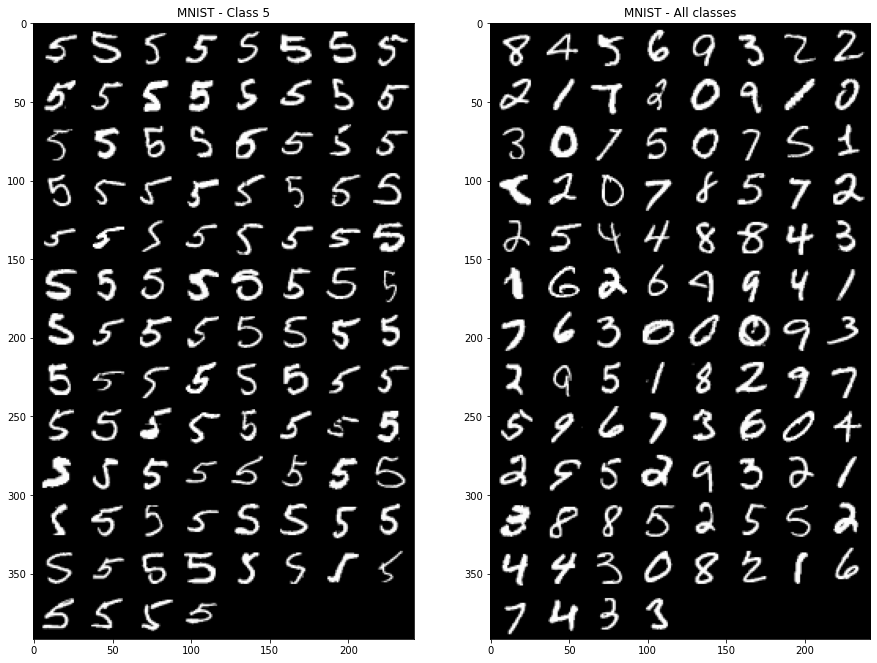

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(15,15))

# Example of how to load several images of the whole dataset
for images, _ in data_loader:
    sample_images = make_grid(denorm(images))
    break

# Example of how to load several images of a specific class
for images, _ in class_data_loader:
    class_sample_images = make_grid(denorm(images))
    break

axs[0].imshow(class_sample_images.permute(1, 2, 0), cmap='gray', vmin=0, vmax=255)
axs[0].set_title(f"{str(chosen_dataset).upper()} - Class {chosen_class}")

axs[1].imshow(sample_images.permute(1, 2, 0), cmap='gray', vmin=0, vmax=255)
axs[1].set_title(f"{str(chosen_dataset.upper())} - All classes")
f.show()

### Train Model

**TODO**: Now it's time to fill the gaps of the following training function.

1. Define variables `fake_labels` and `real_labels` and load them in the GPU at the start of each step. You can copy the code snippet from PART 1, but you should change it a little bit (see the tip below). 

2. Assign to `input_z` a noise-vector $z$ of shape (*batch_size*, *latent_size*) using `torch.randn()`. Assign to `input_images` a flattened version of `images`, taking into account that `images` has a shape of (*batch_size*, *channels*, *height*, *width*) and $D$ expects a tensor of shape (*batch_size*, *image_size*), where *image_size* = *channels* $\cdot$ *height* $\cdot$ *width*. Don't forget to load both tensors in the GPU. 

3. Compute the loss value of the discriminator. 
   * Use variables `input_images` and `input_z` as input of the networks when neeeded.
   * Use variables `fake_labels` and `real_labels` to compute loss values.

4. Compute the loss value of the generator (you will also need some of the variables specified on the third bullet point). Assign to `fake_images` the output of $G$ in order to save some visualizations during the generator's training step. This way we'll be able to check what $G$ is generating during training.

*Tip*: You can copy the code snippets from part 1 and slightly adapt them for this function. Be careful with the `batch_size` variable. On some steps the real batch size may change, so you should use a variable that is updated on each iteration of the training process...

In [ ]:
def train_gan(generator, discriminator, data_loader, criterion, optimizers, device, sample_dir, k, num_epochs, latent_size, conditional_gan=False, vis_epoch=50):

    # Create output directory if it doesn't exist
    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    # Extract optimizers
    g_optimizer, d_optimizer = optimizers

    # Start training
    total_step = len(data_loader)
    t = tqdm(range(num_epochs), desc="Epochs: ")

    for epoch in t:
        for i, (images, labels) in enumerate(data_loader):
           
            # images.size() -> (current_batch_size, channels, height, width)
            # labels.size() -> (current_batch_size,)
            
            # ================================================================== #
            #                         Prepare GAN inputs                         #
            # ================================================================== #
            
            current_batch_size, c, h, w = images.size()

            # TODO 1. Create labels which are later used as input for the BCE loss
            real_labels, fake_labels = None, None
            ### WRITE YOUR CODE HERE ### (~2 lines)
            fake_labels = torch.zeros((current_batch_size,1)).to(device)
            real_labels = torch.ones((current_batch_size,1)).to(device)
            ############################ 

            input_images, input_z = None, None
            # TODO 2. Generate/reshape the input values of the networks
            ### WRITE YOUR CODE HERE ### (~2 lines)
            input_images = images.reshape(current_batch_size, -1).to(device)
            input_z = torch.randn(current_batch_size, latent_size).to(device)

            ############################

            # LEAVE IT EMPTY UNTIL PART 3
            # TODO 5.1. Adapt the input tensors for Conditional GANs (PART 3)
            ### WRITE YOUR CODE HERE ### (~4 lines in PART 3)


            ############################

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #

            for _ in range(k):

                d_loss = None
                # TODO 3. Compute the loss of the discriminator
                # TODO 5.2. Adapt the loss of the discriminator for Conditional GANs (PART 3)
                ### WRITE YOUR CODE HERE ### (~6 lines, ~8 lines in PART 3)
                fake_data = G(input_z)
                fake_res = D(fake_data)
                l1 = criterion(fake_res, fake_labels)
                real_res = D(input_images)
                l2 = criterion(real_res, real_labels)
                d_loss = l1+l2

                ############################

                reset_grad()
                d_loss.backward()
                d_optimizer.step()
                
            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #

            g_loss, fake_images = None, None
            # TODO 4. Compute the loss of the generator
            # TODO 5.3. Adapt the loss of the generator for Conditional GANs (PART 3)
            ### WRITE YOUR CODE HERE ### (~3 lines, ~7 lines in PART 3)
            fake_images = G(input_z)
            fake_res = D(fake_images)
            g_loss = criterion(fake_res, real_labels)
            
            ############################
            
            # Backprop and optimize
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
                
        t.set_description('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                .format(epoch + 1, num_epochs, d_loss.item(), g_loss.item()))

        # Save real images only in the first iteration (as reference)
        if epoch == 0:
            images = images.reshape(current_batch_size, c, h, w)
            save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
        
        # Save sampled images every 
        if (epoch + 1) % vis_epoch == 0 or epoch == 0:
            fake_images = fake_images.reshape(current_batch_size, c, h, w)
            save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))
        

#### One class only (Fast)

In order to check if the function above is well implemented, run the cell below to train our GAN model on generating the digit you previously chose.

In [ ]:
output_dir = f'samples_{chosen_dataset}_{chosen_class}'
optimizers = (g_optimizer, d_optimizer)
vis_epoch = 50

train_gan(G, D, class_data_loader, criterion, optimizers, device, output_dir, k, num_epochs, latent_size, conditional_gan=False, vis_epoch=vis_epoch)

Epoch [800/800], d_loss: 0.6468, g_loss: 2.6609: 100%|██████████| 800/800 [04:46<00:00,  2.79it/s]


During training, if you go to the 📁 icon in the left-side tab of Colab, you'll be able to find a folder specifying your chosen dataset and class (as an example, *samples_mnist_5*). Inside, you can find some samples of the real images (samples from $p_{data}$) and fake images (samples from $p_g$) on different epochs of the training. These images can be opened in Colab double-clicking on them.

For example, *fake_images-50.png* will show some of the images generated during the 50th epoch of training. The frequency of these images is controlled by the variable *vis_epoch* (you can change it if you want). By default it will generate a set of samples every 50 epochs.

What are you going to see in these samples?
* Epoch 1: $G$ hasn't got any time to learn anything, so it generates noisy images.
* Epoch 50: $G$ is learning the shape of your chosen digit. It usually generates the same image, disregarding the values of $z$. However, these digits are still noisy/cloudy.
* Epoch 100+: $D$ has already learnt to distinguish between the same shape that $G$ was creating during the 50th epoch and the real images. $G$ is now forced to generate variations of your chosen digit to fool $D$, but this won't be an easy task.
* Epoch 800: At the end of the training process you'll see that the quantity and quality of shapes of your chosen digit has increased. Nevertheless, it is still easy for us to distinguish between real and fake images, as there are some "dead" pixels that appear in generated images...

**Quick question**: will this be fixed increasing the number of epochs or is it due to another constraint of our current model/dataset?

I said it was a quick question, not easy to answer... Meanwhile, with the cell below you'll be able to save the networks in two different files. This way, you'll be able to load it in PART 4 if you want. It doesn't matter if you don't save it, as we already provide a pretrained model for this purpose.

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), f'G_{chosen_dataset}_{chosen_class}.ckpt')
torch.save(D.state_dict(), f'D_{chosen_dataset}_{chosen_class}.ckpt')

#### All classes (Slow)

We are now going to create another instance of our GAN model. This time we are going to generate images with digits that go from 0 to 9. This means that $p_{data}$ has now become more complex to replicate, and, therefore, it will be harder for our model to replicate samples from that distribution.

In [ ]:
G_all, D_all = create_gan_model(image_size, latent_size, hidden_size)

# Device setting
G_all = G_all.to(device)
D_all = D_all.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G_all.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(D_all.parameters(), lr=learning_rate)

**DISCLAIMER**: Please, don't run the following cell during the lab sessions, it takes too long! (~55 minutes)

In [ ]:
### GAN with all classes
num_epochs = 200
output_dir = f'samples_{chosen_dataset}'
optimizers = (g_optimizer, d_optimizer)

train_gan(G_all, D_all, data_loader, criterion, optimizers, device, output_dir, k, num_epochs, latent_size, vis_epoch=5)

Epoch [26/200], d_loss: 1.0874, g_loss: 2.3459:  13%|█▎        | 26/200 [05:33<37:12, 12.83s/it]


KeyboardInterrupt: ignored

Quick description of the learning process of this GAN model.
* Epoch 1: $G$ hasn't got any time to learn anything, so, as before, it generates noisy images.
* Epoch 5: $G$ is learning the average shape of all ten digits at the same time. It usually generates the same cloudy image, disregarding the values of $z$. $D$ will soon learn this pattern and $G$ will need to generate different shapes in order to fool $D$.
* Epoch 15: Now, we are able to start seeing the first semi-defined shapes. You may start seeing some amalgamate of digits in them.
* Epoch 20+: We start seeing the first defined digits, even though some digits are much more frequent than others. In the following epochs $G$ will try to generate each digit with the same frequency, greater quality and higher diversity.
* Epoch 200: Some of the generated images have become quite difficult to distinguish from real images, whereas a few of them still don't have well-defined digits.


Again, we will save the generated model with the following cell.

In [ ]:
# Save the model checkpoints 
torch.save(G_all.state_dict(), f'G_{chosen_dataset}.ckpt')
torch.save(D_all.state_dict(), f'D_{chosen_dataset}.ckpt')

## PART 3: Conditional GANs

In this part we will adapt the code done in PART 2 to support Conditional GANs. But, first of all, let's remember what a conditional GAN is.

### Quick recap

As the name implies, in conditional GANs (CGANs) both the generator and discriminator are conditioned on some extra information $c$. $c$ could be any kind of auxiliary information, such as class labels or another type of data. This conditioning can be performed by feeding $c$
into both $D$ and $G$ as additional data in their input layer, as shown in the following image.

<img src="https://www.programmersought.com/images/782/335c540c7c5fc7113d44bbb82484ce0e.png"/>

Taking the case of MNIST, this means that we can control what digit will $G$ generate by explicitly specifying the class label in its input. 

However, CGAN has a drawback, as it needs labelled data in order to train the model. Luckily, MNIST contains the labels we need.

For those curious, following the minimax game that we defined in PART 1 for GANs, this is the formula that describes this minimax algorithm in the case of CGANs:

$$\min_{G} \max_{D} V(D,G) = \mathbb{E}_{x \sim p_{data}}[\log (D(x|c))] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z|c)))]$$

In this function:

*    $G(z|c)$ is the generator's output when a noise-vector (or random number in this case) $z$ is given as input conditioned by $c$, which defines a class label.
*    $D(G(z|c))$ is the discriminator's estimate of the probability that a fake instance is real conditioned by $c$.
*    $D(x|c)$ is the discriminator's estimate of the probability that real data instance $x$ is real conditioned by $c$.
*    $\mathbb{E}_{x \sim p_{data}}$ is the expected value over all real data instances.
*    $\mathbb{E}_{z \sim p_{z}}$ is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances $G(z)$).


### Implementation

For this implementation, we will use a one hot vector of ten elements to represent all classes/digits and feed it alongside the inputs of $G$ and $D$, so we'll need to adapt the code in PART 2.

**TODO**: Make changes in two functions of PART 2: `create_gan_model()` and `train_gan()`. The goal is to be able to use them for the initalization and training process of both GANs and CGANs, so be careful on how you change them!

1. `create_gan_model()`: This function will initialize GAN and CGAN models.

  * Add the value of `label_size` when needed. `label_size` will be 0 if we want to create a classic GAN or a positive value (the number of unique classes in our dataset) in case of a CGAN.

2. `train_gan()`: This function will train both GAN and CGAN models.
  * Be careful with the changes you make in this function. Use an *if* statement for each change you make using the boolean `conditional_gan` which is set to *True* when a CGAN is being trained or set to *False* when a GAN is being trained.
  * TODO 5.1: Just before the training step of $D$, we'll need to change both `input_z` and `input_images`, concatenating $c$ to them (a one hot vector of 10 elements). We provide the function `to_one_hot()`, that takes variable `labels` of shape (*batch_size*,) as input and returns their respective one-hot vectors $c$ in a tensor of shape (*batch_size*, *label_size*). Use it.
  
    * Before the code snippet you need to implement, these variables will have a shape of (*batch_size*, *latent_size*) and (*batch_size*, *image_size*), respectively. After your implementation, the shape should change to (*batch_size*, *latent_size* + *label_size*) and (*batch_size*, *image_size* + *label_size*), respectively. Use the same $c$ for both *input_z* and *input_images*

  * TODO 5.2 & 5.3: Each time a forward pass is computed on $G$ during training, you must concatenate $c$ to $G(z)$ in order to feed it to $D$. However, DO NOT overwrite `fake_images`, use another variable name (we use `fake_images` to create .png files and we don't want $c$ in them).


### Training

The following cell will create both $G$ and $D$ of our CGAN Model. To check if the changes have been made correctly, look at the number of parameters on each network. We use the same `latent_size`, `hidden_size` and `image_size` as before, but we set `label_size` to 10, so our CGAN model should be slightly bigger than our GAN.

In total, $G$ should have 286,480 parameters, whereas $D$ should have 269,569. 

In [ ]:
label_size = 10

G_c, D_c = create_gan_model(image_size, latent_size, hidden_size, label_size)

# Device setting
D_c = D_c.to(device)
G_c = G_c.to(device)

print("Generator")
summary(G_c, (latent_size + label_size,))
print("\nDiscriminator")
summary(D_c, (image_size + label_size,))

As always, we need to define the loss function and the optimizers...

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D_c.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G_c.parameters(), lr=learning_rate)

optimizers = (g_optimizer, d_optimizer)

... and train the model. 

In [ ]:
num_epochs = 20 # 200

### Conditional GAN
output_dir = f'samples_{chosen_dataset}_cgan'
train_gan(G_c, D_c, data_loader, criterion, optimizers, device, output_dir, k, num_epochs, latent_size, conditional_gan=True, vis_epoch=5)

Run it just for 15-20 epochs. You should be able to see some cloudy/noisy digits by then. If that's the case your code is working well! Don't try to run the training for the 200 epochs we used earlier. This way the training would take around 65 minutes and, again, we provide some pretrained weights of the model in order to easily load them in PART 4. Don't waste your time!

If you want to save your half-trained model, execute the next cell.

In [ ]:
 # Save the model checkpoints 
torch.save(G_c.state_dict(), f'G_c_{chosen_dataset}.ckpt')
torch.save(D_c.state_dict(), f'D_c_{chosen_dataset}.ckpt')

## PART 4: Qualitative analysis

In this final part we will first see some examples of the generated images, interpolating values of the input noise-vector $z$, and, then we'll observe some qualities that we can exploit of the CGAN model.

In the cell below, you'll find 3 pretrained GAN models, which are the ones that can be trained in PART 2 and PART 3. We'll load them to see their generated images. You can uncomment the ones that you haven't trained/saved or you could change the filenames to load your own.

In [ ]:
# UNCOMMENT TO LOAD OUR PRETRAINED CLASSIC GAN WITH THE DIGIT 5
# G, D = create_gan_model(784, 64, 256)
# G.load_state_dict(torch.load("mlnn_lab7.1/G_mnist_5.ckpt", map_location=torch.device('cpu')))
# D.load_state_dict(torch.load("mlnn_lab7.1/D_mnist_5.ckpt", map_location=torch.device('cpu')))

# UNCOMMENT TO LOAD OUR PRETRAINED CLASSIC GAN WITH ALL DIGITS
# G_all, D_all = create_gan_model(784, 64, 256)
# G_all.load_state_dict(torch.load("mlnn_lab7.1/G_mnist.ckpt", map_location=torch.device('cpu')))
# D_all.load_state_dict(torch.load("mlnn_lab7.1/D_mnist.ckpt", map_location=torch.device('cpu')))

# UNCOMMENT TO LOAD OUR PRETRAINED CONDITIONAL GAN 
# G_c, D_c = create_gan_model(784, 64, 256, 10) 
# G_c.load_state_dict(torch.load("mlnn_lab7.1/cG_mnist.ckpt", map_location=torch.device('cpu')))
# D_c.load_state_dict(torch.load("mlnn_lab7.1/cD_mnist.ckpt", map_location=torch.device('cpu')));

### Visualize examples

First of all, we will visualize the images that these three models generate given $n = 64$ samples of $z$ (and $c$ in case of the CGAN).

In [ ]:
n = 64
ch = 1
h, w = 28, 28

z = torch.randn(n, latent_size)
c = torch.randint(10, size=(n,)) # Randomly create labels for CGAN
cz = torch.cat([z, to_one_hot(c)], dim=1)

images = G(z)
images = images.reshape((n, ch, h, w))
gan_images = make_grid(denorm(images))

images = G_all(z)
images = images.reshape(n, ch, h, w)
gan_all_images = make_grid(denorm(images))

images = G_c(cz)
images = images.reshape(n, ch, h, w)
cgan_images = make_grid(denorm(images))

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(12, 36))

axs[0].imshow(gan_images.permute(1, 2, 0), cmap='gray', vmin=0, vmax=255)
axs[0].set_title(f"GAN - One Class")

axs[1].imshow(gan_all_images.permute(1, 2, 0), cmap='gray', vmin=0, vmax=255)
axs[1].set_title(f"GAN - All Classes")

axs[2].imshow(cgan_images.permute(1, 2, 0), cmap='gray', vmin=0, vmax=255)
axs[2].set_title(f"CGAN")

f.show()

print("# Labels used in images generated by CGAN")
print(c.reshape(8,8))

Our GAN that has been trained with only one class seems to be the noisiest out of the three models. 

Meanwhile, the GAN that has been trained with all classes generates the digit 1 with more frequency than the other digits, even though the generated images are less cloudy.

This last GAN and the CGAN models offer a higher quality in the images, but in the former some of the images are cloudy and in the latter we can control the generated images by hand. So, in this case, CGAN has shown to offer more diversity and quality than the other two models.

### Latent space interpolation

We could say that $G$ learns to project a sample from a continuous latent space into an image, so samples that are close in the latent space will generate similar images. 

In this experiment, we'll randomly sample three $z$ noise-vectors and compute linear interpolations between them in order to generate interpolated images of handwritten digits (or clothes, if you have trained your own models with Fashion MNIST). 

These interpolations will always follow the same cycle ($z_1 \rightarrow z_2 \rightarrow z_3 \rightarrow z_1$), and for each interpolated value we'll generate an image to finally create a GIF animated file and show it in this notebook.

We will show these animations with four different setups.

1. Using a GAN that generates one class (top-left corner in the gif below).
2. Using a GAN that can generate all classes (bottom-left corner).
3. Using a CGAN that (due to its input) is conditioned to generate only one class (top-right corner).
4. Using a CGAN that is conditioned to generate three different digits, one digit per sampled noise-vector (bottom-right corner).

All four setups use the same latent samples $z_1$, $z_2$ and $z_3$.

In [ ]:
# Random noise-vectors: z
z1 = torch.randn(1, latent_size)
z2 = torch.randn(1, latent_size)
z3 = torch.randn(1, latent_size)

# One hot vectors: c
label_a = to_one_hot(torch.tensor([2]))
label_b = to_one_hot(torch.tensor([7]))
label_c = to_one_hot(torch.tensor([3])) # This one is used for the 3rd setup

# Concatenations of z and c for the 3rd setup
cz1_same = torch.cat([z1, label_c], dim=1)
cz2_same = torch.cat([z2, label_c], dim=1)
cz3_same = torch.cat([z3, label_c], dim=1)

# Concatenations of z and c for the 4th setup
cz1 = torch.cat([z1, label_a], dim=1)
cz2 = torch.cat([z2, label_b], dim=1)
cz3 = torch.cat([z3, label_c], dim=1)

In [ ]:
# Create dictionaries of all the data needed to create the animation
inputs_dict = {
    "z1": z1, "z2": z2, "z3": z3,
    "cz1": cz1, "cz2": cz2, "cz3": cz3,
    "cz1_same": cz1_same, "cz2_same": cz2_same, "cz3_same": cz3_same,
}

models = {
    "G": G, "G_all": G_all, "G_c": G_c
}

The following cell generates a .gif file with the animation. It's a neat animation that shows the potential of these GAN models.

In [ ]:
%matplotlib inline
filename = "latent_space_interpolation.gif"
create_gif(filename, inputs_dict, models, frames=400)
show_gif(filename)

As we don't define any seed, each run of the cell above will generate a different interpolation. You are free to change $c$ in order to check different interpolations of handwritten digits with the CGAN models.

What do you think? Which setup do you like most?

### CGANs - What does the latent space learn?

If $G$ is the generator of a CGAN model, its input will be the concatenation of a latent sample $z$ and the one-hot vector $c$ that represents the label. If $c$ specifies which will be the generated image's digit, how does $z$ affect the output?

In the following cell we generate one image per class using the same $z$ sample. We also add a case where $c$ doesn't specify any label, that is, a case where $c$ is a vector full of zeros. 

Run this several times and see if there is any pattern in the generated images.

In [ ]:
# Generate sample z
z = torch.randn(1, latent_size)
cz = torch.cat([z, torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])], dim=1)

f, axs = plt.subplots(3, 4, figsize=(6,7))

# Iterate over all classes and plot the generated images using the same z
for i in range(11):
    
    if i < 10:
        cz[0, latent_size + i] = 1

    image = G_c(cz)
    image = denorm(image)
    image = image.reshape(1, 28, 28).detach()
    image = torch.cat([image, image, image], dim=0)
    image = image.permute(1, 2, 0)

    axs[i // 4, i % 4].imshow(image, cmap='gray', vmin=0, vmax=255)
    axs[i // 4, i % 4].set_title(f"Label: {str(i)}")
    axs[i // 4, i % 4].axis("off")

    if i < 10:
        cz[0, latent_size + i] = 0
    
    if i == 10:
        axs[i // 4, i % 4].set_title("No label")

axs[2, 3].axis("off");

In these plots, you may see that each $z$ defines a different "font" or "style" of the digits. A given $z$ may even specify a font similar to the one used in "Times New Roman", whereas another may define a "Comic Sans"-like font.

Jokes aside, CGANs give us more control on the generated image, as we can specify explicitly both class and shape of the generated image.

### CGANs - Generating the unseen

If we want, CGANs have enough flexibility to generate images that don't follow the training data's distribution. We can specify manually what we want in $c$. For example, we could mix different digits into one image.

Let's choose a class $i$, and see what happens when we try to generate images mixing $i$ with the other classes in pairs.

In [ ]:
# {display-mode: "form", run: "auto"}

i = 0 #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] {type: "raw"}

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

if chosen_dataset == "fashion_mnist":
    print("Chosen class: {labels_map[chosen_class]}")

In [ ]:
z = torch.randn(1, latent_size)
cz = torch.cat([z, torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])], dim=1)

f, axs = plt.subplots(1, 10, figsize=(15,1.5))

print(f"Mixing {i} with other digits")

for j in range(10):

    axs[j].axis('off')
    
    cz[0, latent_size + i] = 1
    cz[0, latent_size + j] = 1

    image = G_c(cz)
    image = denorm(image)
    image = image.reshape(1, 28, 28).detach()
    image = torch.cat([image, image, image], dim=0)
    image = image.permute(1, 2, 0)

    axs[j].set_title(str(j))
    axs[j].imshow(image, cmap='gray', vmin=0, vmax=255)

    cz[0, latent_size + i] = 0
    cz[0, latent_size + j] = 0

For example, in the case of $i = 0$ we can clearly see how the model tries to fit each number in the shape of a 0. 